# Experimentieren mit genetischem Algorithmus - GAExperiment
In diesem Notebook sollen die Teilnehmer den genetischen Algorithmus selbst konfigurieren und ablaufen lassen. Als interaktives Element können nach jeder
Generation gezielt Mutationen durchgeführt werden um zu beobachten, ob diese einen selektiven Vorteil bieten.


In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
# Only if multiple GPUs available
from tqdm import tqdm
import pandas
import os
import glob
from multiprocessing import Pool, Process
from collections import OrderedDict
from subprocess import Popen, STDOUT,  PIPE

In [6]:
%%capture
import tensorflow as tf

2023-07-06 12:10:05.250899: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:10:05.326883: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [7]:
%%capture
from gahyparopt.gahyperopt import *
from gahyparopt.widgets import *

In [8]:
mnist = load_data()

## Anfangskonfiguration

In [9]:
population_size = 8
best_candidates_count = 1
random_candidates_count=2
name = "Carsten"

In [10]:
GA=GADriver(
        layer_counts=HIDDEN_LAYER_COUNT,
        no_neurons=HIDDEN_LAYER_NEURONS,
        rates=HIDDEN_LAYER_RATE,
        activations=HIDDEN_LAYER_ACTIVATIONS,
        layer_types=HIDDEN_LAYER_TYPE,
        optimizers=MODEL_OPTIMIZER,
        number_of_epochs=MODEL_EPOCHS,
        steps_per_epoch=MODEL_STEPS_PER_EPOCH,
        population_size=population_size,
        best_candidates_count=best_candidates_count,
        random_candidates_count=random_candidates_count,
        optimizer_mutation_probability=OPTIMIZER_MUTATION_PROBABILITY,
        layer_mutation_probability=HIDDEN_LAYER_MUTATION_PROBABILITY,
    )


## Erste Generation

In [11]:
%%capture
population = GA.generate_first_population_randomly()

2023-07-06 12:10:10.181508: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:10:14.039831: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9671 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5
2023-07-06 12:10:14.041070: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9671 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1b:00.0, compute capability: 7.5
2023-07-06 12:10:14.042155: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Creat

In [12]:
population

In [13]:
def population_report(population):
    for i,chrm in enumerate(population):

        print("="*80)
        print("---"+" Chromosome {}".format(chrm.id) + " ---")
        print(f"Optimizer: {chrm.optimizer}")
        print(f"number_of_epochs: {chrm.number_of_epochs}")
        print(f"steps_per_epoch: {chrm.steps_per_epoch}")
        print(f"number of hidden layers: {len(chrm.layer_layout)}")

        print("Layers:")
        for i,layer in enumerate(chrm.layer_layout):
            print(i,layer.__dict__)
            
        print("-"*80)
        print(f"Accuracy: {chrm.accuracy}")

In [14]:
population_report(population)

--- Chromosome yhpx ---
Optimizer: adam
number_of_epochs: 10
steps_per_epoch: 50
number of hidden layers: 1
Layers:
0 {'neurons': None, 'activation': None, 'rate': 0.1, 'layer_type': 'dropout'}
--------------------------------------------------------------------------------
Accuracy: None
--- Chromosome wfpk ---
Optimizer: rmsprop
number_of_epochs: 3
steps_per_epoch: 50
number of hidden layers: 2
Layers:
0 {'neurons': None, 'activation': None, 'rate': 0.2, 'layer_type': 'dropout'}
1 {'neurons': 8, 'activation': 'relu', 'rate': None, 'layer_type': 'dense'}
--------------------------------------------------------------------------------
Accuracy: None
--- Chromosome qpqj ---
Optimizer: sgd
number_of_epochs: 2
steps_per_epoch: 50
number of hidden layers: 1
Layers:
0 {'neurons': 64, 'activation': 'relu', 'rate': None, 'layer_type': 'dense'}
--------------------------------------------------------------------------------
Accuracy: None
--- Chromosome bkcm ---
Optimizer: sgd
number_of_epochs

### Entwicklungsstadium (Training)

In [15]:
import shlex

In [16]:
python = sys.executable

In [17]:
python

'/scratch/grotec/mambaforge/envs/evolai/bin/python3.9'

In [18]:
for json in glob.glob("*.json"):
    os.remove(json)

In [19]:
def develop(*args):
    i, chrm = args
    
    write_chromosome(chrm.id, chrm)
    cmd = shlex.split(f'{python} -m gahyparopt.gahyperopt {chrm.id} {i}')
    proc = Popen(cmd, shell=False)
    
    return proc

In [20]:
generations = []
for generation in range(100):
    clear_keras_session()
    
    procs = [develop(i,chrm) for i,chrm in enumerate(population)]
    while any([proc.poll() != 0 for proc in procs]):
        continue

    population = sort_population([read_chromosome(chrm.id) for chrm in population])
    
    generations.append([(chrm.id, chrm.accuracy, chrm.parent_a, chrm.parent_b) for chrm in population])
    
    population = GA.evolve_population(population)
    

2023-07-06 12:13:06.193331: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:13:06.278782: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:13:06.318844: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
kpto None None
yhpx None None
axeg None None
ubfy None None
wfpk None None
qpqj None None
jift None None
bkcm None None
*** Parents taken over ***
kpto None None
*** Random parents ***
jift None None
bkcm None None
*** New generation ***
kpto kpto kpto
jift jift jift
bkcm bkcm bkcm
zknl jift bkcm
foox jift bkcm
oacn kpto jift
ycqr bkcm kpto
ckgw bkcm jift


2023-07-06 12:13:33.431903: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:13:33.519035: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:13:33.560870: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
kpto kpto kpto
oacn kpto jift
ycqr bkcm kpto
zknl jift bkcm
jift jift jift
ckgw bkcm jift
foox jift bkcm
bkcm bkcm bkcm
*** Parents taken over ***
kpto kpto kpto
*** Random parents ***
zknl jift bkcm
jift jift jift
*** New generation ***
kpto kpto kpto
zknl zknl zknl
jift jift jift
eecv zknl jift
fzdy jift kpto
qupc zknl kpto
qsye zknl jift
gfdq zknl jift


2023-07-06 12:14:03.643503: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:14:03.729867: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:14:03.824184: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
qsye zknl jift
qupc zknl kpto
kpto kpto kpto
fzdy jift kpto
eecv zknl jift
gfdq zknl jift
zknl zknl zknl
jift jift jift
*** Parents taken over ***
qsye zknl jift
*** Random parents ***
kpto kpto kpto
fzdy jift kpto
*** New generation ***
qsye qsye qsye
kpto kpto kpto
fzdy fzdy fzdy
adze qsye kpto
nbhk fzdy qsye
fiqz kpto qsye
baki qsye kpto
bgdy fzdy qsye


2023-07-06 12:14:35.495934: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:14:35.583722: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:14:35.617689: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
qsye qsye qsye
baki qsye kpto
fiqz kpto qsye
bgdy fzdy qsye
kpto kpto kpto
fzdy fzdy fzdy
nbhk fzdy qsye
adze qsye kpto
*** Parents taken over ***
qsye qsye qsye
*** Random parents ***
adze qsye kpto
fzdy fzdy fzdy
*** New generation ***
qsye qsye qsye
adze adze adze
fzdy fzdy fzdy
jhhs adze qsye
fhcz adze qsye
oexm qsye adze
dshx adze qsye
omdy fzdy adze


2023-07-06 12:15:05.331321: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:15:05.417593: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:15:05.454018: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
qsye qsye qsye
jhhs adze qsye
oexm qsye adze
fzdy fzdy fzdy
fhcz adze qsye
dshx adze qsye
adze adze adze
omdy fzdy adze
*** Parents taken over ***
qsye qsye qsye
*** Random parents ***
omdy fzdy adze
fzdy fzdy fzdy
*** New generation ***
qsye qsye qsye
omdy omdy omdy
fzdy fzdy fzdy
kpqg fzdy qsye
siii fzdy qsye
bywp fzdy omdy
murn omdy fzdy
ptmr omdy qsye


2023-07-06 12:15:30.231975: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:15:30.317678: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:15:30.362578: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
qsye qsye qsye
siii fzdy qsye
kpqg fzdy qsye
fzdy fzdy fzdy
murn omdy fzdy
bywp fzdy omdy
omdy omdy omdy
ptmr omdy qsye
*** Parents taken over ***
qsye qsye qsye
*** Random parents ***
ptmr omdy qsye
ptmr omdy qsye
*** New generation ***
qsye qsye qsye
ptmr ptmr ptmr
ptmr ptmr ptmr
zhdi ptmr qsye
yutd ptmr qsye
pqxz ptmr qsye
jzop qsye ptmr
peub ptmr qsye


2023-07-06 12:15:56.691423: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:15:56.774814: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:15:56.814005: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
yutd ptmr qsye
qsye qsye qsye
peub ptmr qsye
zhdi ptmr qsye
pqxz ptmr qsye
jzop qsye ptmr
ptmr ptmr ptmr
ptmr ptmr ptmr
*** Parents taken over ***
yutd ptmr qsye
*** Random parents ***
qsye qsye qsye
pqxz ptmr qsye
*** New generation ***
yutd yutd yutd
qsye qsye qsye
pqxz pqxz pqxz
qubn pqxz qsye
mdpy pqxz qsye
xbgb yutd pqxz
qwpm yutd qsye
mzpx pqxz qsye


2023-07-06 12:16:20.576473: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:16:20.660543: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:16:20.698769: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
qwpm yutd qsye
qsye qsye qsye
mzpx pqxz qsye
xbgb yutd pqxz
yutd yutd yutd
qubn pqxz qsye
pqxz pqxz pqxz
mdpy pqxz qsye
*** Parents taken over ***
qwpm yutd qsye
*** Random parents ***
xbgb yutd pqxz
pqxz pqxz pqxz
*** New generation ***
qwpm qwpm qwpm
xbgb xbgb xbgb
pqxz pqxz pqxz
pnrk xbgb qwpm
nvso qwpm pqxz
apju xbgb pqxz
tyje xbgb pqxz
bteu qwpm xbgb


2023-07-06 12:16:45.366289: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:16:45.454147: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:16:45.543637: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
qwpm qwpm qwpm
pnrk xbgb qwpm
tyje xbgb pqxz
xbgb xbgb xbgb
bteu qwpm xbgb
pqxz pqxz pqxz
apju xbgb pqxz
nvso qwpm pqxz
*** Parents taken over ***
qwpm qwpm qwpm
*** Random parents ***
apju xbgb pqxz
pnrk xbgb qwpm
*** New generation ***
qwpm qwpm qwpm
apju apju apju
pnrk pnrk pnrk
ucdr qwpm apju
jxlb qwpm apju
ozoe pnrk qwpm
gzev pnrk apju
bfpf qwpm pnrk


2023-07-06 12:17:10.491372: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:17:10.583632: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:17:10.618528: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
bfpf qwpm pnrk
pnrk pnrk pnrk
qwpm qwpm qwpm
jxlb qwpm apju
ozoe pnrk qwpm
ucdr qwpm apju
gzev pnrk apju
apju apju apju
*** Parents taken over ***
bfpf qwpm pnrk
*** Random parents ***
pnrk pnrk pnrk
gzev pnrk apju
*** New generation ***
bfpf bfpf bfpf
pnrk pnrk pnrk
gzev gzev gzev
bglb gzev bfpf
znrw bfpf pnrk
cyqr bfpf pnrk
hhxw bfpf gzev
pazg bfpf gzev


2023-07-06 12:17:36.036138: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:17:36.120602: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:17:36.165057: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
bglb gzev bfpf
bfpf bfpf bfpf
znrw bfpf pnrk
hhxw bfpf gzev
pnrk pnrk pnrk
cyqr bfpf pnrk
pazg bfpf gzev
gzev gzev gzev
*** Parents taken over ***
bglb gzev bfpf
*** Random parents ***
hhxw bfpf gzev
gzev gzev gzev
*** New generation ***
bglb bglb bglb
hhxw hhxw hhxw
gzev gzev gzev
zshr bglb gzev
xvzu gzev bglb
obyx hhxw bglb
qjyq hhxw gzev
fwcl hhxw bglb


2023-07-06 12:17:59.415360: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:17:59.499677: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:17:59.547166: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
obyx hhxw bglb
fwcl hhxw bglb
hhxw hhxw hhxw
bglb bglb bglb
xvzu gzev bglb
zshr bglb gzev
gzev gzev gzev
qjyq hhxw gzev
*** Parents taken over ***
obyx hhxw bglb
*** Random parents ***
zshr bglb gzev
bglb bglb bglb
*** New generation ***
obyx obyx obyx
zshr zshr zshr
bglb bglb bglb
csfm obyx bglb
fbpb bglb obyx
wkar bglb obyx
qbbs bglb zshr
obin obyx zshr


2023-07-06 12:18:23.733590: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:18:23.827125: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:18:23.854316: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
obyx obyx obyx
bglb bglb bglb
wkar bglb obyx
fbpb bglb obyx
obin obyx zshr
qbbs bglb zshr
zshr zshr zshr
csfm obyx bglb
*** Parents taken over ***
obyx obyx obyx
*** Random parents ***
qbbs bglb zshr
qbbs bglb zshr
*** New generation ***
obyx obyx obyx
qbbs qbbs qbbs
qbbs qbbs qbbs
txke qbbs obyx
tbqj qbbs obyx
gyul qbbs obyx
rivk qbbs obyx
npvj qbbs obyx


2023-07-06 12:18:47.112863: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:18:47.210535: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:18:47.289293: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
txke qbbs obyx
obyx obyx obyx
gyul qbbs obyx
rivk qbbs obyx
qbbs qbbs qbbs
qbbs qbbs qbbs
tbqj qbbs obyx
npvj qbbs obyx
*** Parents taken over ***
txke qbbs obyx
*** Random parents ***
obyx obyx obyx
rivk qbbs obyx
*** New generation ***
txke txke txke
obyx obyx obyx
rivk rivk rivk
azef rivk txke
gpld rivk obyx
bjgf obyx rivk
bonv obyx rivk
ropg obyx rivk


2023-07-06 12:19:10.886981: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:19:10.984758: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:19:11.068157: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
azef rivk txke
gpld rivk obyx
obyx obyx obyx
txke txke txke
ropg obyx rivk
rivk rivk rivk
bonv obyx rivk
bjgf obyx rivk
*** Parents taken over ***
azef rivk txke
*** Random parents ***
bonv obyx rivk
ropg obyx rivk
*** New generation ***
azef azef azef
bonv bonv bonv
ropg ropg ropg
hnxw ropg azef
otoi bonv ropg
rlhb bonv ropg
twis bonv ropg
hqet ropg bonv


2023-07-06 12:19:34.910279: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:19:34.995863: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:19:35.041954: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
azef azef azef
hnxw ropg azef
ropg ropg ropg
otoi bonv ropg
hqet ropg bonv
rlhb bonv ropg
bonv bonv bonv
twis bonv ropg
*** Parents taken over ***
azef azef azef
*** Random parents ***
ropg ropg ropg
hqet ropg bonv
*** New generation ***
azef azef azef
ropg ropg ropg
hqet hqet hqet
hmkn azef hqet
oxfk azef ropg
gqsg azef ropg
fnmb azef hqet
tbul hqet ropg


2023-07-06 12:19:58.730019: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:19:58.829922: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:19:58.905690: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
gqsg azef ropg
fnmb azef hqet
azef azef azef
hqet hqet hqet
hmkn azef hqet
oxfk azef ropg
tbul hqet ropg
ropg ropg ropg
*** Parents taken over ***
gqsg azef ropg
*** Random parents ***
tbul hqet ropg
hqet hqet hqet
*** New generation ***
gqsg gqsg gqsg
tbul tbul tbul
hqet hqet hqet
wlrx gqsg tbul
lydf tbul hqet
yqxg hqet tbul
bvtd hqet tbul
mrhx hqet gqsg


2023-07-06 12:20:23.847682: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:20:23.947415: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:20:24.020613: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
gqsg gqsg gqsg
wlrx gqsg tbul
bvtd hqet tbul
yqxg hqet tbul
mrhx hqet gqsg
hqet hqet hqet
tbul tbul tbul
lydf tbul hqet
*** Parents taken over ***
gqsg gqsg gqsg
*** Random parents ***
yqxg hqet tbul
lydf tbul hqet
*** New generation ***
gqsg gqsg gqsg
yqxg yqxg yqxg
lydf lydf lydf
bmbu gqsg yqxg
qgcm yqxg gqsg
iity gqsg yqxg
himr gqsg yqxg
dbpl yqxg gqsg


2023-07-06 12:20:49.028953: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:20:49.129260: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:20:49.202486: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
iity gqsg yqxg
gqsg gqsg gqsg
bmbu gqsg yqxg
qgcm yqxg gqsg
himr gqsg yqxg
dbpl yqxg gqsg
yqxg yqxg yqxg
lydf lydf lydf
*** Parents taken over ***
iity gqsg yqxg
*** Random parents ***
bmbu gqsg yqxg
lydf lydf lydf
*** New generation ***
iity iity iity
bmbu bmbu bmbu
lydf lydf lydf
uona lydf bmbu
ikmt bmbu iity
wnjd iity lydf
bckr bmbu iity
ddjr bmbu iity


2023-07-06 12:21:15.559335: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:21:15.657676: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:21:15.728374: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
iity iity iity
ddjr bmbu iity
bmbu bmbu bmbu
ikmt bmbu iity
bckr bmbu iity
wnjd iity lydf
lydf lydf lydf
uona lydf bmbu
*** Parents taken over ***
iity iity iity
*** Random parents ***
lydf lydf lydf
bckr bmbu iity
*** New generation ***
iity iity iity
lydf lydf lydf
bckr bckr bckr
eumz lydf bckr
hedo iity bckr
edrq lydf iity
wfyk lydf bckr
tpzd bckr lydf


2023-07-06 12:21:39.504108: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:21:39.602779: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:21:39.700047: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
hedo iity bckr
iity iity iity
bckr bckr bckr
tpzd bckr lydf
wfyk lydf bckr
edrq lydf iity
lydf lydf lydf
eumz lydf bckr
*** Parents taken over ***
hedo iity bckr
*** Random parents ***
eumz lydf bckr
iity iity iity
*** New generation ***
hedo hedo hedo
eumz eumz eumz
iity iity iity
kzxv hedo eumz
kmse hedo eumz
apzm hedo eumz
nqys eumz hedo
jlkr eumz hedo


2023-07-06 12:22:04.523091: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:22:04.621202: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:22:04.683156: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
iity iity iity
hedo hedo hedo
apzm hedo eumz
nqys eumz hedo
kmse hedo eumz
kzxv hedo eumz
eumz eumz eumz
jlkr eumz hedo
*** Parents taken over ***
iity iity iity
*** Random parents ***
jlkr eumz hedo
jlkr eumz hedo
*** New generation ***
iity iity iity
jlkr jlkr jlkr
jlkr jlkr jlkr
xkjt jlkr iity
qsce jlkr iity
qpnh jlkr iity
mvwl iity jlkr
cdcc jlkr iity


2023-07-06 12:22:28.668051: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:22:28.765637: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:22:28.842121: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
iity iity iity
qpnh jlkr iity
mvwl iity jlkr
cdcc jlkr iity
qsce jlkr iity
xkjt jlkr iity
jlkr jlkr jlkr
jlkr jlkr jlkr
*** Parents taken over ***
iity iity iity
*** Random parents ***
qsce jlkr iity
qpnh jlkr iity
*** New generation ***
iity iity iity
qsce qsce qsce
qpnh qpnh qpnh
ktix iity qpnh
aowb iity qsce
obml qpnh qsce
xoce iity qsce
aptk iity qpnh


2023-07-06 12:22:52.653172: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:22:52.750827: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:22:52.839661: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
iity iity iity
aowb iity qsce
aptk iity qpnh
qpnh qpnh qpnh
xoce iity qsce
ktix iity qpnh
obml qpnh qsce
qsce qsce qsce
*** Parents taken over ***
iity iity iity
*** Random parents ***
obml qpnh qsce
ktix iity qpnh
*** New generation ***
iity iity iity
obml obml obml
ktix ktix ktix
uddc obml ktix
cdch obml ktix
ytfg ktix obml
rxzv obml ktix
beyn obml ktix


2023-07-06 12:23:17.946711: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:23:18.047383: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:23:18.128678: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
iity iity iity
rxzv obml ktix
uddc obml ktix
beyn obml ktix
cdch obml ktix
ktix ktix ktix
obml obml obml
ytfg ktix obml
*** Parents taken over ***
iity iity iity
*** Random parents ***
ktix ktix ktix
rxzv obml ktix
*** New generation ***
iity iity iity
ktix ktix ktix
rxzv rxzv rxzv
mlbe ktix iity
rfet iity rxzv
sbza iity ktix
nlrh ktix iity
phlt rxzv iity


2023-07-06 12:23:42.513663: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:23:42.612754: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:23:42.686313: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
iity iity iity
sbza iity ktix
phlt rxzv iity
rfet iity rxzv
rxzv rxzv rxzv
mlbe ktix iity
nlrh ktix iity
ktix ktix ktix
*** Parents taken over ***
iity iity iity
*** Random parents ***
ktix ktix ktix
rxzv rxzv rxzv
*** New generation ***
iity iity iity
ktix ktix ktix
rxzv rxzv rxzv
rcrx ktix iity
xaqf ktix iity
wiyn iity rxzv
useg rxzv ktix
siju iity rxzv


2023-07-06 12:24:07.137078: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:24:07.234453: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:24:07.304481: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
iity iity iity
siju iity rxzv
xaqf ktix iity
rxzv rxzv rxzv
useg rxzv ktix
ktix ktix ktix
wiyn iity rxzv
rcrx ktix iity
*** Parents taken over ***
iity iity iity
*** Random parents ***
ktix ktix ktix
siju iity rxzv
*** New generation ***
iity iity iity
ktix ktix ktix
siju siju siju
xkdd ktix iity
vaek ktix iity
neod siju iity
djyk ktix iity
ywac ktix iity


2023-07-06 12:24:31.956878: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:24:32.055492: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:24:32.123654: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
ywac ktix iity
iity iity iity
djyk ktix iity
neod siju iity
siju siju siju
xkdd ktix iity
vaek ktix iity
ktix ktix ktix
*** Parents taken over ***
ywac ktix iity
*** Random parents ***
vaek ktix iity
vaek ktix iity
*** New generation ***
ywac ywac ywac
vaek vaek vaek
vaek vaek vaek
qrzm vaek ywac
rblp vaek ywac
btbq ywac vaek
pwfz vaek ywac
xuzp vaek ywac


2023-07-06 12:24:58.599743: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:24:58.684026: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:24:58.727994: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
pwfz vaek ywac
qrzm vaek ywac
btbq ywac vaek
ywac ywac ywac
xuzp vaek ywac
rblp vaek ywac
vaek vaek vaek
vaek vaek vaek
*** Parents taken over ***
pwfz vaek ywac
*** Random parents ***
xuzp vaek ywac
vaek vaek vaek
*** New generation ***
pwfz pwfz pwfz
xuzp xuzp xuzp
vaek vaek vaek
wxca xuzp pwfz
garw vaek pwfz
qhlo pwfz vaek
umza vaek xuzp
asrb xuzp vaek


2023-07-06 12:25:24.472251: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:25:24.564823: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:25:24.604526: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
pwfz pwfz pwfz
garw vaek pwfz
xuzp xuzp xuzp
qhlo pwfz vaek
umza vaek xuzp
vaek vaek vaek
asrb xuzp vaek
wxca xuzp pwfz
*** Parents taken over ***
pwfz pwfz pwfz
*** Random parents ***
garw vaek pwfz
umza vaek xuzp
*** New generation ***
pwfz pwfz pwfz
garw garw garw
umza umza umza
tald pwfz umza
sgct umza garw
lneq pwfz garw
lqfx umza garw
suvx umza garw


2023-07-06 12:25:48.462596: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:25:48.547638: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:25:48.595387: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
pwfz pwfz pwfz
garw garw garw
suvx umza garw
lneq pwfz garw
sgct umza garw
lqfx umza garw
umza umza umza
tald pwfz umza
*** Parents taken over ***
pwfz pwfz pwfz
*** Random parents ***
lneq pwfz garw
sgct umza garw
*** New generation ***
pwfz pwfz pwfz
lneq lneq lneq
sgct sgct sgct
fqyg lneq pwfz
mmvr pwfz lneq
rdaq pwfz lneq
mcxo pwfz sgct
gbxi sgct pwfz


2023-07-06 12:26:12.852673: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:26:12.937549: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:26:12.988973: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
gbxi sgct pwfz
pwfz pwfz pwfz
mcxo pwfz sgct
mmvr pwfz lneq
fqyg lneq pwfz
sgct sgct sgct
lneq lneq lneq
rdaq pwfz lneq
*** Parents taken over ***
gbxi sgct pwfz
*** Random parents ***
sgct sgct sgct
sgct sgct sgct
*** New generation ***
gbxi gbxi gbxi
sgct sgct sgct
sgct sgct sgct
dxcq gbxi sgct
mcwh gbxi sgct
torw sgct gbxi
qurb sgct gbxi
yjiv gbxi sgct


2023-07-06 12:26:39.133914: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:26:39.219866: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:26:39.263376: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
torw sgct gbxi
gbxi gbxi gbxi
qurb sgct gbxi
sgct sgct sgct
sgct sgct sgct
yjiv gbxi sgct
dxcq gbxi sgct
mcwh gbxi sgct
*** Parents taken over ***
torw sgct gbxi
*** Random parents ***
gbxi gbxi gbxi
sgct sgct sgct
*** New generation ***
torw torw torw
gbxi gbxi gbxi
sgct sgct sgct
jfzg torw sgct
vlae gbxi torw
gpis gbxi torw
zdgv gbxi sgct
mcfk gbxi torw


2023-07-06 12:27:04.770715: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:27:04.854433: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:27:04.902741: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
vlae gbxi torw
torw torw torw
gbxi gbxi gbxi
gpis gbxi torw
sgct sgct sgct
zdgv gbxi sgct
mcfk gbxi torw
jfzg torw sgct
*** Parents taken over ***
vlae gbxi torw
*** Random parents ***
mcfk gbxi torw
gbxi gbxi gbxi
*** New generation ***
vlae vlae vlae
mcfk mcfk mcfk
gbxi gbxi gbxi
kvrg vlae gbxi
nuhh vlae gbxi
ubqu gbxi mcfk
hqzo vlae gbxi
uegw mcfk vlae


2023-07-06 12:27:29.333186: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:27:29.421312: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:27:29.474852: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
kvrg vlae gbxi
nuhh vlae gbxi
hqzo vlae gbxi
uegw mcfk vlae
vlae vlae vlae
ubqu gbxi mcfk
gbxi gbxi gbxi
mcfk mcfk mcfk
*** Parents taken over ***
kvrg vlae gbxi
*** Random parents ***
vlae vlae vlae
uegw mcfk vlae
*** New generation ***
kvrg kvrg kvrg
vlae vlae vlae
uegw uegw uegw
gxuu uegw kvrg
eskq kvrg uegw
casm uegw kvrg
mprb kvrg vlae
gino uegw kvrg


2023-07-06 12:27:56.203164: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:27:56.287432: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:27:56.337530: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
kvrg kvrg kvrg
casm uegw kvrg
gxuu uegw kvrg
gino uegw kvrg
mprb kvrg vlae
vlae vlae vlae
uegw uegw uegw
eskq kvrg uegw
*** Parents taken over ***
kvrg kvrg kvrg
*** Random parents ***
uegw uegw uegw
mprb kvrg vlae
*** New generation ***
kvrg kvrg kvrg
uegw uegw uegw
mprb mprb mprb
pjek uegw kvrg
zhhz uegw mprb
bhtq kvrg uegw
nbqh mprb kvrg
flpr uegw mprb


2023-07-06 12:28:21.024141: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:28:21.109005: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:28:21.161921: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
nbqh mprb kvrg
kvrg kvrg kvrg
bhtq kvrg uegw
mprb mprb mprb
flpr uegw mprb
uegw uegw uegw
zhhz uegw mprb
pjek uegw kvrg
*** Parents taken over ***
nbqh mprb kvrg
*** Random parents ***
uegw uegw uegw
flpr uegw mprb
*** New generation ***
nbqh nbqh nbqh
uegw uegw uegw
flpr flpr flpr
ayrd uegw nbqh
jcng nbqh flpr
umfh uegw flpr
fgal uegw flpr
gndv nbqh flpr


2023-07-06 12:28:46.484000: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:28:46.575086: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:28:46.611328: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
nbqh nbqh nbqh
ayrd uegw nbqh
fgal uegw flpr
umfh uegw flpr
uegw uegw uegw
flpr flpr flpr
jcng nbqh flpr
gndv nbqh flpr
*** Parents taken over ***
nbqh nbqh nbqh
*** Random parents ***
fgal uegw flpr
flpr flpr flpr
*** New generation ***
nbqh nbqh nbqh
fgal fgal fgal
flpr flpr flpr
kyfu fgal flpr
gzck flpr fgal
qvix flpr fgal
hbll fgal flpr
fqfw flpr nbqh


2023-07-06 12:29:12.018793: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:29:12.110257: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:29:12.161653: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
nbqh nbqh nbqh
fqfw flpr nbqh
fgal fgal fgal
flpr flpr flpr
gzck flpr fgal
qvix flpr fgal
kyfu fgal flpr
hbll fgal flpr
*** Parents taken over ***
nbqh nbqh nbqh
*** Random parents ***
qvix flpr fgal
qvix flpr fgal
*** New generation ***
nbqh nbqh nbqh
qvix qvix qvix
qvix qvix qvix
ccdh nbqh qvix
mwrz qvix nbqh
vxkx qvix nbqh
wyxi nbqh qvix
qkvx nbqh qvix


2023-07-06 12:29:37.986742: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:29:38.078978: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:29:38.119956: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
qkvx nbqh qvix
mwrz qvix nbqh
nbqh nbqh nbqh
ccdh nbqh qvix
qvix qvix qvix
qvix qvix qvix
wyxi nbqh qvix
vxkx qvix nbqh
*** Parents taken over ***
qkvx nbqh qvix
*** Random parents ***
mwrz qvix nbqh
ccdh nbqh qvix
*** New generation ***
qkvx qkvx qkvx
mwrz mwrz mwrz
ccdh ccdh ccdh
zsji ccdh qkvx
wiya ccdh qkvx
etth mwrz qkvx
gavu qkvx ccdh
tzvd mwrz qkvx


2023-07-06 12:30:04.098847: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:30:04.193524: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:30:04.219990: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
etth mwrz qkvx
mwrz mwrz mwrz
gavu qkvx ccdh
qkvx qkvx qkvx
wiya ccdh qkvx
ccdh ccdh ccdh
tzvd mwrz qkvx
zsji ccdh qkvx
*** Parents taken over ***
etth mwrz qkvx
*** Random parents ***
wiya ccdh qkvx
mwrz mwrz mwrz
*** New generation ***
etth etth etth
wiya wiya wiya
mwrz mwrz mwrz
joju etth mwrz
ckie etth mwrz
sdfr etth wiya
nioq mwrz wiya
fqno etth wiya


2023-07-06 12:30:30.785191: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:30:30.869591: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:30:30.914570: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
sdfr etth wiya
etth etth etth
joju etth mwrz
ckie etth mwrz
mwrz mwrz mwrz
fqno etth wiya
nioq mwrz wiya
wiya wiya wiya
*** Parents taken over ***
sdfr etth wiya
*** Random parents ***
ckie etth mwrz
fqno etth wiya
*** New generation ***
sdfr sdfr sdfr
ckie ckie ckie
fqno fqno fqno
wggh fqno ckie
imjo fqno ckie
obwn fqno sdfr
kwzg sdfr fqno
igpf sdfr ckie


2023-07-06 12:30:57.139697: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:30:57.231359: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:30:57.274181: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
obwn fqno sdfr
imjo fqno ckie
ckie ckie ckie
sdfr sdfr sdfr
fqno fqno fqno
wggh fqno ckie
kwzg sdfr fqno
igpf sdfr ckie
*** Parents taken over ***
obwn fqno sdfr
*** Random parents ***
sdfr sdfr sdfr
imjo fqno ckie
*** New generation ***
obwn obwn obwn
sdfr sdfr sdfr
imjo imjo imjo
wihr imjo sdfr
zwrv imjo sdfr
ipqh obwn sdfr
qnhh obwn sdfr
nclg obwn imjo


2023-07-06 12:31:22.976992: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:31:23.068971: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:31:23.112818: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
sdfr sdfr sdfr
ipqh obwn sdfr
zwrv imjo sdfr
imjo imjo imjo
obwn obwn obwn
nclg obwn imjo
qnhh obwn sdfr
wihr imjo sdfr
*** Parents taken over ***
sdfr sdfr sdfr
*** Random parents ***
wihr imjo sdfr
ipqh obwn sdfr
*** New generation ***
sdfr sdfr sdfr
wihr wihr wihr
ipqh ipqh ipqh
oxax ipqh wihr
wdcq sdfr wihr
gbgu wihr sdfr
yvag ipqh wihr
agsf ipqh sdfr


2023-07-06 12:31:48.741377: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:31:48.833462: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:31:48.869131: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
yvag ipqh wihr
sdfr sdfr sdfr
gbgu wihr sdfr
oxax ipqh wihr
wdcq sdfr wihr
ipqh ipqh ipqh
agsf ipqh sdfr
wihr wihr wihr
*** Parents taken over ***
yvag ipqh wihr
*** Random parents ***
agsf ipqh sdfr
oxax ipqh wihr
*** New generation ***
yvag yvag yvag
agsf agsf agsf
oxax oxax oxax
kkus yvag oxax
jfhc yvag agsf
vfgj agsf yvag
nmea oxax yvag
tlqo oxax agsf


2023-07-06 12:32:14.390082: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:32:14.481427: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:32:14.523624: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
yvag yvag yvag
nmea oxax yvag
oxax oxax oxax
jfhc yvag agsf
tlqo oxax agsf
agsf agsf agsf
vfgj agsf yvag
kkus yvag oxax
*** Parents taken over ***
yvag yvag yvag
*** Random parents ***
tlqo oxax agsf
nmea oxax yvag
*** New generation ***
yvag yvag yvag
tlqo tlqo tlqo
nmea nmea nmea
wdns nmea tlqo
njwj tlqo nmea
tiqa yvag tlqo
silk tlqo nmea
qjnp tlqo nmea


2023-07-06 12:32:40.316546: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:32:40.410186: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:32:40.445320: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
nmea nmea nmea
tiqa yvag tlqo
wdns nmea tlqo
tlqo tlqo tlqo
qjnp tlqo nmea
silk tlqo nmea
yvag yvag yvag
njwj tlqo nmea
*** Parents taken over ***
nmea nmea nmea
*** Random parents ***
tiqa yvag tlqo
njwj tlqo nmea
*** New generation ***
nmea nmea nmea
tiqa tiqa tiqa
njwj njwj njwj
cejx njwj nmea
ofig njwj tiqa
dprf tiqa nmea
qxlx nmea njwj
qiti njwj nmea


2023-07-06 12:33:06.225787: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:33:06.310187: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:33:06.353402: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
tiqa tiqa tiqa
cejx njwj nmea
njwj njwj njwj
ofig njwj tiqa
nmea nmea nmea
dprf tiqa nmea
qxlx nmea njwj
qiti njwj nmea
*** Parents taken over ***
tiqa tiqa tiqa
*** Random parents ***
dprf tiqa nmea
njwj njwj njwj
*** New generation ***
tiqa tiqa tiqa
dprf dprf dprf
njwj njwj njwj
wwoo dprf njwj
dzhy dprf njwj
ozxu tiqa njwj
ijwo tiqa njwj
jahd dprf tiqa


2023-07-06 12:33:32.130955: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:33:32.222622: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:33:32.259060: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
tiqa tiqa tiqa
jahd dprf tiqa
wwoo dprf njwj
njwj njwj njwj
dprf dprf dprf
ozxu tiqa njwj
ijwo tiqa njwj
dzhy dprf njwj
*** Parents taken over ***
tiqa tiqa tiqa
*** Random parents ***
jahd dprf tiqa
njwj njwj njwj
*** New generation ***
tiqa tiqa tiqa
jahd jahd jahd
njwj njwj njwj
bssj jahd njwj
wciz njwj tiqa
zovd tiqa jahd
fmsu jahd njwj
rcjh tiqa njwj


2023-07-06 12:34:01.361988: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:34:01.444945: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:34:01.489553: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
jahd jahd jahd
tiqa tiqa tiqa
fmsu jahd njwj
njwj njwj njwj
wciz njwj tiqa
rcjh tiqa njwj
zovd tiqa jahd
bssj jahd njwj
*** Parents taken over ***
jahd jahd jahd
*** Random parents ***
fmsu jahd njwj
wciz njwj tiqa
*** New generation ***
jahd jahd jahd
fmsu fmsu fmsu
wciz wciz wciz
tnjx wciz jahd
cwjs fmsu wciz
reev jahd wciz
oeop wciz fmsu
ijvh jahd wciz


2023-07-06 12:34:26.367915: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:34:26.460143: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:34:26.500944: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
wciz wciz wciz
cwjs fmsu wciz
tnjx wciz jahd
ijvh jahd wciz
jahd jahd jahd
fmsu fmsu fmsu
oeop wciz fmsu
reev jahd wciz
*** Parents taken over ***
wciz wciz wciz
*** Random parents ***
jahd jahd jahd
ijvh jahd wciz
*** New generation ***
wciz wciz wciz
jahd jahd jahd
ijvh ijvh ijvh
icsn wciz jahd
wuup jahd wciz
hpad jahd ijvh
ibrj wciz jahd
fvru ijvh wciz


2023-07-06 12:34:51.034338: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:34:51.126762: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:34:51.171868: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
ibrj wciz jahd
jahd jahd jahd
wciz wciz wciz
fvru ijvh wciz
hpad jahd ijvh
wuup jahd wciz
ijvh ijvh ijvh
icsn wciz jahd
*** Parents taken over ***
ibrj wciz jahd
*** Random parents ***
ijvh ijvh ijvh
jahd jahd jahd
*** New generation ***
ibrj ibrj ibrj
ijvh ijvh ijvh
jahd jahd jahd
siat jahd ijvh
lcxf ijvh ibrj
epsq jahd ibrj
ulgb jahd ibrj
gskz ijvh jahd


2023-07-06 12:35:16.109300: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:35:16.202927: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:35:16.250461: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
lcxf ijvh ibrj
gskz ijvh jahd
ibrj ibrj ibrj
siat jahd ijvh
jahd jahd jahd
ijvh ijvh ijvh
ulgb jahd ibrj
epsq jahd ibrj
*** Parents taken over ***
lcxf ijvh ibrj
*** Random parents ***
siat jahd ijvh
ijvh ijvh ijvh
*** New generation ***
lcxf lcxf lcxf
siat siat siat
ijvh ijvh ijvh
teqc ijvh lcxf
prqi siat lcxf
vche siat ijvh
tmav lcxf siat
jbqt ijvh lcxf


2023-07-06 12:35:41.773289: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:35:41.858362: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:35:41.914965: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
lcxf lcxf lcxf
vche siat ijvh
siat siat siat
teqc ijvh lcxf
tmav lcxf siat
jbqt ijvh lcxf
ijvh ijvh ijvh
prqi siat lcxf
*** Parents taken over ***
lcxf lcxf lcxf
*** Random parents ***
tmav lcxf siat
prqi siat lcxf
*** New generation ***
lcxf lcxf lcxf
tmav tmav tmav
prqi prqi prqi
bggc prqi lcxf
ykbk tmav prqi
ybif lcxf tmav
cyvy prqi lcxf
vfuc tmav lcxf


2023-07-06 12:36:11.458953: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:36:11.543798: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:36:11.584023: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
ybif lcxf tmav
vfuc tmav lcxf
tmav tmav tmav
lcxf lcxf lcxf
bggc prqi lcxf
ykbk tmav prqi
prqi prqi prqi
cyvy prqi lcxf
*** Parents taken over ***
ybif lcxf tmav
*** Random parents ***
tmav tmav tmav
vfuc tmav lcxf
*** New generation ***
ybif ybif ybif
tmav tmav tmav
vfuc vfuc vfuc
sekl ybif tmav
bvrl vfuc ybif
oeis vfuc tmav
efjc ybif tmav
xorm vfuc tmav


2023-07-06 12:36:37.933331: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:36:38.018405: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:36:38.135454: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
vfuc vfuc vfuc
ybif ybif ybif
sekl ybif tmav
bvrl vfuc ybif
tmav tmav tmav
efjc ybif tmav
oeis vfuc tmav
xorm vfuc tmav
*** Parents taken over ***
vfuc vfuc vfuc
*** Random parents ***
oeis vfuc tmav
bvrl vfuc ybif
*** New generation ***
vfuc vfuc vfuc
oeis oeis oeis
bvrl bvrl bvrl
wnam vfuc bvrl
erdu vfuc oeis
mxmy bvrl oeis
xkcc vfuc bvrl
cuzw vfuc oeis


2023-07-06 12:37:03.313727: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:37:03.405657: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:37:03.433414: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
bvrl bvrl bvrl
wnam vfuc bvrl
vfuc vfuc vfuc
oeis oeis oeis
cuzw vfuc oeis
mxmy bvrl oeis
xkcc vfuc bvrl
erdu vfuc oeis
*** Parents taken over ***
bvrl bvrl bvrl
*** Random parents ***
wnam vfuc bvrl
xkcc vfuc bvrl
*** New generation ***
bvrl bvrl bvrl
wnam wnam wnam
xkcc xkcc xkcc
zcgd wnam bvrl
gecy wnam xkcc
trxs bvrl xkcc
ezsh xkcc wnam
erpb wnam xkcc


2023-07-06 12:37:27.513567: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:37:27.603269: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:37:27.643200: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
wnam wnam wnam
bvrl bvrl bvrl
zcgd wnam bvrl
trxs bvrl xkcc
ezsh xkcc wnam
gecy wnam xkcc
xkcc xkcc xkcc
erpb wnam xkcc
*** Parents taken over ***
wnam wnam wnam
*** Random parents ***
trxs bvrl xkcc
erpb wnam xkcc
*** New generation ***
wnam wnam wnam
trxs trxs trxs
erpb erpb erpb
qefo trxs erpb
xyyv erpb wnam
uefa wnam erpb
kayg trxs erpb
wdek wnam trxs


2023-07-06 12:37:55.921336: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:37:56.006183: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:37:56.048159: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
xyyv erpb wnam
wdek wnam trxs
wnam wnam wnam
kayg trxs erpb
qefo trxs erpb
trxs trxs trxs
erpb erpb erpb
uefa wnam erpb
*** Parents taken over ***
xyyv erpb wnam
*** Random parents ***
erpb erpb erpb
wdek wnam trxs
*** New generation ***
xyyv xyyv xyyv
erpb erpb erpb
wdek wdek wdek
awjx wdek erpb
kzul xyyv erpb
jymj xyyv wdek
hevb erpb xyyv
pllj wdek erpb


2023-07-06 12:38:23.876512: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:38:23.969495: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:38:24.005242: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
hevb erpb xyyv
wdek wdek wdek
jymj xyyv wdek
xyyv xyyv xyyv
kzul xyyv erpb
pllj wdek erpb
erpb erpb erpb
awjx wdek erpb
*** Parents taken over ***
hevb erpb xyyv
*** Random parents ***
erpb erpb erpb
wdek wdek wdek
*** New generation ***
hevb hevb hevb
erpb erpb erpb
wdek wdek wdek
qcbr hevb erpb
xook wdek erpb
dndc erpb wdek
hjxh wdek hevb
qkse erpb wdek


2023-07-06 12:38:50.671387: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:38:50.763502: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:38:50.815133: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
hevb hevb hevb
wdek wdek wdek
qkse erpb wdek
qcbr hevb erpb
hjxh wdek hevb
dndc erpb wdek
erpb erpb erpb
xook wdek erpb
*** Parents taken over ***
hevb hevb hevb
*** Random parents ***
dndc erpb wdek
qcbr hevb erpb
*** New generation ***
hevb hevb hevb
dndc dndc dndc
qcbr qcbr qcbr
wiln hevb dndc
trmi qcbr hevb
fswr dndc hevb
inxp dndc hevb
ezma dndc hevb


2023-07-06 12:39:19.281154: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:39:19.368205: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:39:19.411005: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
qcbr qcbr qcbr
trmi qcbr hevb
hevb hevb hevb
ezma dndc hevb
inxp dndc hevb
dndc dndc dndc
wiln hevb dndc
fswr dndc hevb
*** Parents taken over ***
qcbr qcbr qcbr
*** Random parents ***
wiln hevb dndc
dndc dndc dndc
*** New generation ***
qcbr qcbr qcbr
wiln wiln wiln
dndc dndc dndc
qpsi wiln qcbr
feti wiln dndc
ljxk wiln qcbr
qerz qcbr wiln
qkjw wiln dndc


2023-07-06 12:39:46.605671: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:39:46.697486: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:39:46.748659: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
qerz qcbr wiln
qcbr qcbr qcbr
qkjw wiln dndc
wiln wiln wiln
feti wiln dndc
dndc dndc dndc
ljxk wiln qcbr
qpsi wiln qcbr
*** Parents taken over ***
qerz qcbr wiln
*** Random parents ***
qcbr qcbr qcbr
dndc dndc dndc
*** New generation ***
qerz qerz qerz
qcbr qcbr qcbr
dndc dndc dndc
kkoy dndc qerz
ijct qerz qcbr
msvd dndc qerz
nwfw qerz qcbr
ouxx qerz qcbr


2023-07-06 12:40:13.333394: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:40:13.417169: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:40:13.488030: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
qerz qerz qerz
ouxx qerz qcbr
nwfw qerz qcbr
qcbr qcbr qcbr
dndc dndc dndc
msvd dndc qerz
kkoy dndc qerz
ijct qerz qcbr
*** Parents taken over ***
qerz qerz qerz
*** Random parents ***
msvd dndc qerz
kkoy dndc qerz
*** New generation ***
qerz qerz qerz
msvd msvd msvd
kkoy kkoy kkoy
gdwj qerz msvd
qaao msvd qerz
mies msvd kkoy
nxfm kkoy qerz
wbfk qerz kkoy


2023-07-06 12:40:41.469590: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:40:41.554963: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:40:41.600150: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
nxfm kkoy qerz
qerz qerz qerz
mies msvd kkoy
kkoy kkoy kkoy
msvd msvd msvd
gdwj qerz msvd
qaao msvd qerz
wbfk qerz kkoy
*** Parents taken over ***
nxfm kkoy qerz
*** Random parents ***
wbfk qerz kkoy
qaao msvd qerz
*** New generation ***
nxfm nxfm nxfm
wbfk wbfk wbfk
qaao qaao qaao
gvsy wbfk nxfm
habc nxfm qaao
yeuo wbfk qaao
chrj wbfk qaao
jfsa nxfm qaao


2023-07-06 12:41:11.998205: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:41:12.080994: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:41:12.127350: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
nxfm nxfm nxfm
gvsy wbfk nxfm
habc nxfm qaao
qaao qaao qaao
yeuo wbfk qaao
wbfk wbfk wbfk
chrj wbfk qaao
jfsa nxfm qaao
*** Parents taken over ***
nxfm nxfm nxfm
*** Random parents ***
chrj wbfk qaao
habc nxfm qaao
*** New generation ***
nxfm nxfm nxfm
chrj chrj chrj
habc habc habc
mlgs habc chrj
qopq chrj nxfm
zvvv chrj nxfm
rwpb habc nxfm
eihw habc nxfm


2023-07-06 12:41:41.012318: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:41:41.096495: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:41:41.149412: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
eihw habc nxfm
nxfm nxfm nxfm
zvvv chrj nxfm
rwpb habc nxfm
habc habc habc
chrj chrj chrj
mlgs habc chrj
qopq chrj nxfm
*** Parents taken over ***
eihw habc nxfm
*** Random parents ***
habc habc habc
chrj chrj chrj
*** New generation ***
eihw eihw eihw
habc habc habc
chrj chrj chrj
yqkv chrj habc
bpko eihw habc
wkfw chrj eihw
yjig habc chrj
sloz habc eihw


2023-07-06 12:42:09.103802: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:42:09.198236: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:42:09.224008: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
eihw eihw eihw
wkfw chrj eihw
habc habc habc
yqkv chrj habc
yjig habc chrj
chrj chrj chrj
bpko eihw habc
sloz habc eihw
*** Parents taken over ***
eihw eihw eihw
*** Random parents ***
wkfw chrj eihw
chrj chrj chrj
*** New generation ***
eihw eihw eihw
wkfw wkfw wkfw
chrj chrj chrj
egtu eihw chrj
jjet chrj eihw
tzqc wkfw chrj
ello chrj wkfw
jahd wkfw chrj


2023-07-06 12:42:36.994117: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:42:37.086120: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:42:37.118658: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
eihw eihw eihw
wkfw wkfw wkfw
ello chrj wkfw
jahd wkfw chrj
chrj chrj chrj
tzqc wkfw chrj
egtu eihw chrj
jjet chrj eihw
*** Parents taken over ***
eihw eihw eihw
*** Random parents ***
ello chrj wkfw
jjet chrj eihw
*** New generation ***
eihw eihw eihw
ello ello ello
jjet jjet jjet
kndh eihw ello
wnzl jjet ello
pahd jjet ello
bhbo ello eihw
ztoo jjet ello


2023-07-06 12:43:06.310950: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:43:06.396885: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:43:06.440334: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
eihw eihw eihw
bhbo ello eihw
kndh eihw ello
ello ello ello
wnzl jjet ello
ztoo jjet ello
jjet jjet jjet
pahd jjet ello
*** Parents taken over ***
eihw eihw eihw
*** Random parents ***
bhbo ello eihw
ello ello ello
*** New generation ***
eihw eihw eihw
bhbo bhbo bhbo
ello ello ello
braf eihw ello
yszq bhbo eihw
oujx eihw ello
ngez ello bhbo
kopg eihw ello


2023-07-06 12:43:34.538655: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:43:34.629731: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:43:34.678684: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
yszq bhbo eihw
eihw eihw eihw
bhbo bhbo bhbo
braf eihw ello
ngez ello bhbo
ello ello ello
oujx eihw ello
kopg eihw ello
*** Parents taken over ***
yszq bhbo eihw
*** Random parents ***
ngez ello bhbo
oujx eihw ello
*** New generation ***
yszq yszq yszq
ngez ngez ngez
oujx oujx oujx
vhmp ngez yszq
uphq oujx yszq
ugag yszq ngez
cuyp oujx yszq
wwyw yszq oujx


2023-07-06 12:44:03.230183: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:44:03.321162: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:44:03.360426: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
yszq yszq yszq
vhmp ngez yszq
ngez ngez ngez
ugag yszq ngez
oujx oujx oujx
wwyw yszq oujx
uphq oujx yszq
cuyp oujx yszq
*** Parents taken over ***
yszq yszq yszq
*** Random parents ***
cuyp oujx yszq
vhmp ngez yszq
*** New generation ***
yszq yszq yszq
cuyp cuyp cuyp
vhmp vhmp vhmp
qcwa cuyp yszq
tbso vhmp cuyp
qoek cuyp vhmp
vtrf yszq vhmp
brjs vhmp cuyp


2023-07-06 12:44:30.575515: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:44:30.660341: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:44:30.710785: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
yszq yszq yszq
vhmp vhmp vhmp
vtrf yszq vhmp
qoek cuyp vhmp
qcwa cuyp yszq
brjs vhmp cuyp
cuyp cuyp cuyp
tbso vhmp cuyp
*** Parents taken over ***
yszq yszq yszq
*** Random parents ***
cuyp cuyp cuyp
vhmp vhmp vhmp
*** New generation ***
yszq yszq yszq
cuyp cuyp cuyp
vhmp vhmp vhmp
ctyv cuyp vhmp
rscp yszq cuyp
itkl cuyp yszq
ddab yszq cuyp
tjxr yszq cuyp


2023-07-06 12:44:57.775453: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:44:57.874721: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:44:57.963633: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
yszq yszq yszq
vhmp vhmp vhmp
ddab yszq cuyp
itkl cuyp yszq
ctyv cuyp vhmp
tjxr yszq cuyp
cuyp cuyp cuyp
rscp yszq cuyp
*** Parents taken over ***
yszq yszq yszq
*** Random parents ***
rscp yszq cuyp
ctyv cuyp vhmp
*** New generation ***
yszq yszq yszq
rscp rscp rscp
ctyv ctyv ctyv
gvbq ctyv yszq
zdrz ctyv yszq
henp ctyv rscp
xjnz yszq rscp
xjdh rscp ctyv


2023-07-06 12:45:24.931457: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:45:25.029099: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:45:25.110999: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
yszq yszq yszq
gvbq ctyv yszq
xjdh rscp ctyv
ctyv ctyv ctyv
xjnz yszq rscp
zdrz ctyv yszq
henp ctyv rscp
rscp rscp rscp
*** Parents taken over ***
yszq yszq yszq
*** Random parents ***
ctyv ctyv ctyv
rscp rscp rscp
*** New generation ***
yszq yszq yszq
ctyv ctyv ctyv
rscp rscp rscp
tbai ctyv rscp
krlk yszq ctyv
silh ctyv rscp
fprf yszq ctyv
zmoa rscp ctyv


2023-07-06 12:45:52.538551: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:45:52.636676: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:45:52.688903: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
fprf yszq ctyv
yszq yszq yszq
krlk yszq ctyv
tbai ctyv rscp
ctyv ctyv ctyv
zmoa rscp ctyv
rscp rscp rscp
silh ctyv rscp
*** Parents taken over ***
fprf yszq ctyv
*** Random parents ***
yszq yszq yszq
silh ctyv rscp
*** New generation ***
fprf fprf fprf
yszq yszq yszq
silh silh silh
ppxj fprf yszq
sujd silh fprf
szal yszq silh
datg fprf yszq
zkpy yszq silh


2023-07-06 12:46:23.030135: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:46:23.129214: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:46:23.204614: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
ppxj fprf yszq
yszq yszq yszq
fprf fprf fprf
datg fprf yszq
szal yszq silh
sujd silh fprf
zkpy yszq silh
silh silh silh
*** Parents taken over ***
ppxj fprf yszq
*** Random parents ***
silh silh silh
zkpy yszq silh
*** New generation ***
ppxj ppxj ppxj
silh silh silh
zkpy zkpy zkpy
epzs zkpy ppxj
kttw ppxj silh
kghn silh ppxj
kdoq silh ppxj
ibji ppxj silh


2023-07-06 12:46:50.682705: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:46:50.782691: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:46:50.863426: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
ppxj ppxj ppxj
epzs zkpy ppxj
kdoq silh ppxj
kttw ppxj silh
silh silh silh
zkpy zkpy zkpy
ibji ppxj silh
kghn silh ppxj
*** Parents taken over ***
ppxj ppxj ppxj
*** Random parents ***
kdoq silh ppxj
kghn silh ppxj
*** New generation ***
ppxj ppxj ppxj
kdoq kdoq kdoq
kghn kghn kghn
ybcy kdoq kghn
ypgc kghn ppxj
rnqh ppxj kghn
kxor ppxj kdoq
xtzz kdoq kghn


2023-07-06 12:47:19.840163: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:47:19.926292: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:47:19.974176: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
ppxj ppxj ppxj
kxor ppxj kdoq
ypgc kghn ppxj
ybcy kdoq kghn
kdoq kdoq kdoq
xtzz kdoq kghn
kghn kghn kghn
rnqh ppxj kghn
*** Parents taken over ***
ppxj ppxj ppxj
*** Random parents ***
ypgc kghn ppxj
ybcy kdoq kghn
*** New generation ***
ppxj ppxj ppxj
ypgc ypgc ypgc
ybcy ybcy ybcy
msfs ypgc ppxj
vuwm ypgc ybcy
kmpl ppxj ypgc
knua ybcy ypgc
zyqn ybcy ppxj


2023-07-06 12:47:49.121286: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:47:49.220631: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:47:49.297795: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
ppxj ppxj ppxj
msfs ypgc ppxj
kmpl ppxj ypgc
zyqn ybcy ppxj
ypgc ypgc ypgc
vuwm ypgc ybcy
ybcy ybcy ybcy
knua ybcy ypgc
*** Parents taken over ***
ppxj ppxj ppxj
*** Random parents ***
kmpl ppxj ypgc
msfs ypgc ppxj
*** New generation ***
ppxj ppxj ppxj
kmpl kmpl kmpl
msfs msfs msfs
xmrq ppxj kmpl
xstu ppxj kmpl
augz kmpl ppxj
puaa msfs kmpl
fbwg ppxj msfs


2023-07-06 12:48:19.440925: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:48:19.533768: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:48:19.570951: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
ppxj ppxj ppxj
fbwg ppxj msfs
msfs msfs msfs
augz kmpl ppxj
kmpl kmpl kmpl
xmrq ppxj kmpl
xstu ppxj kmpl
puaa msfs kmpl
*** Parents taken over ***
ppxj ppxj ppxj
*** Random parents ***
fbwg ppxj msfs
fbwg ppxj msfs
*** New generation ***
ppxj ppxj ppxj
fbwg fbwg fbwg
fbwg fbwg fbwg
kjcd ppxj fbwg
qpey ppxj fbwg
mbyr fbwg ppxj
dbdn ppxj fbwg
btty fbwg ppxj


2023-07-06 12:48:48.754026: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:48:48.850735: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:48:48.933574: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
fbwg fbwg fbwg
fbwg fbwg fbwg
ppxj ppxj ppxj
dbdn ppxj fbwg
btty fbwg ppxj
mbyr fbwg ppxj
qpey ppxj fbwg
kjcd ppxj fbwg
*** Parents taken over ***
fbwg fbwg fbwg
*** Random parents ***
btty fbwg ppxj
fbwg fbwg fbwg
*** New generation ***
fbwg fbwg fbwg
btty btty btty
fbwg fbwg fbwg
eqha fbwg btty
eeys fbwg btty
slno btty fbwg
glii btty fbwg
teoj fbwg btty


2023-07-06 12:49:16.440845: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:49:16.538703: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:49:16.612920: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
fbwg fbwg fbwg
fbwg fbwg fbwg
slno btty fbwg
teoj fbwg btty
btty btty btty
glii btty fbwg
eeys fbwg btty
eqha fbwg btty
*** Parents taken over ***
fbwg fbwg fbwg
*** Random parents ***
fbwg fbwg fbwg
eqha fbwg btty
*** New generation ***
fbwg fbwg fbwg
fbwg fbwg fbwg
eqha eqha eqha
rtkt fbwg eqha
odsv fbwg eqha
drhz fbwg eqha
clme fbwg eqha
kglq fbwg eqha


2023-07-06 12:49:44.467643: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:49:44.564256: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:49:44.646192: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
rtkt fbwg eqha
fbwg fbwg fbwg
fbwg fbwg fbwg
drhz fbwg eqha
odsv fbwg eqha
kglq fbwg eqha
eqha eqha eqha
clme fbwg eqha
*** Parents taken over ***
rtkt fbwg eqha
*** Random parents ***
eqha eqha eqha
drhz fbwg eqha
*** New generation ***
rtkt rtkt rtkt
eqha eqha eqha
drhz drhz drhz
ctyb rtkt drhz
ldvy drhz rtkt
oypf rtkt drhz
uthx eqha drhz
spbo eqha rtkt


2023-07-06 12:50:13.697841: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:50:13.795650: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:50:13.873103: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
rtkt rtkt rtkt
ctyb rtkt drhz
ldvy drhz rtkt
oypf rtkt drhz
drhz drhz drhz
spbo eqha rtkt
uthx eqha drhz
eqha eqha eqha
*** Parents taken over ***
rtkt rtkt rtkt
*** Random parents ***
eqha eqha eqha
drhz drhz drhz
*** New generation ***
rtkt rtkt rtkt
eqha eqha eqha
drhz drhz drhz
afkw drhz rtkt
mfbe eqha rtkt
bgdu eqha rtkt
mrhp eqha drhz
asyg drhz rtkt


2023-07-06 12:50:41.970990: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:50:42.068736: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:50:42.145326: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
asyg drhz rtkt
rtkt rtkt rtkt
afkw drhz rtkt
drhz drhz drhz
bgdu eqha rtkt
mrhp eqha drhz
mfbe eqha rtkt
eqha eqha eqha
*** Parents taken over ***
asyg drhz rtkt
*** Random parents ***
drhz drhz drhz
mrhp eqha drhz
*** New generation ***
asyg asyg asyg
drhz drhz drhz
mrhp mrhp mrhp
cpaj drhz mrhp
oiea mrhp drhz
rssz mrhp drhz
qqqy mrhp drhz
siud mrhp asyg


2023-07-06 12:51:12.519987: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:51:12.618289: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:51:12.691699: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
asyg asyg asyg
oiea mrhp drhz
drhz drhz drhz
cpaj drhz mrhp
rssz mrhp drhz
mrhp mrhp mrhp
siud mrhp asyg
qqqy mrhp drhz
*** Parents taken over ***
asyg asyg asyg
*** Random parents ***
qqqy mrhp drhz
rssz mrhp drhz
*** New generation ***
asyg asyg asyg
qqqy qqqy qqqy
rssz rssz rssz
bvom asyg rssz
jzql asyg qqqy
sfkd asyg rssz
jwcx rssz asyg
fnij asyg rssz


2023-07-06 12:51:40.204796: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:51:40.302567: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:51:40.396146: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
asyg asyg asyg
jwcx rssz asyg
rssz rssz rssz
fnij asyg rssz
bvom asyg rssz
sfkd asyg rssz
qqqy qqqy qqqy
jzql asyg qqqy
*** Parents taken over ***
asyg asyg asyg
*** Random parents ***
fnij asyg rssz
bvom asyg rssz
*** New generation ***
asyg asyg asyg
fnij fnij fnij
bvom bvom bvom
mjet asyg bvom
llxo fnij bvom
lqrw asyg fnij
kcty fnij asyg
qwfc asyg fnij


2023-07-06 12:52:08.696447: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:52:08.795260: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:52:08.875903: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
asyg asyg asyg
kcty fnij asyg
mjet asyg bvom
llxo fnij bvom
qwfc asyg fnij
lqrw asyg fnij
fnij fnij fnij
bvom bvom bvom
*** Parents taken over ***
asyg asyg asyg
*** Random parents ***
fnij fnij fnij
llxo fnij bvom
*** New generation ***
asyg asyg asyg
fnij fnij fnij
llxo llxo llxo
yhiy fnij asyg
vlnq llxo asyg
bzuk asyg llxo
ivdf fnij asyg
lnbu asyg fnij


2023-07-06 12:52:38.444187: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:52:38.541588: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:52:38.606562: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
vlnq llxo asyg
asyg asyg asyg
fnij fnij fnij
llxo llxo llxo
yhiy fnij asyg
ivdf fnij asyg
bzuk asyg llxo
lnbu asyg fnij
*** Parents taken over ***
vlnq llxo asyg
*** Random parents ***
ivdf fnij asyg
fnij fnij fnij
*** New generation ***
vlnq vlnq vlnq
ivdf ivdf ivdf
fnij fnij fnij
eitm ivdf vlnq
yzff fnij ivdf
ojnz ivdf fnij
dkao ivdf fnij
kydf ivdf vlnq


2023-07-06 12:53:06.686180: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:53:06.784825: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:53:06.851426: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
vlnq vlnq vlnq
kydf ivdf vlnq
eitm ivdf vlnq
fnij fnij fnij
dkao ivdf fnij
ojnz ivdf fnij
ivdf ivdf ivdf
yzff fnij ivdf
*** Parents taken over ***
vlnq vlnq vlnq
*** Random parents ***
kydf ivdf vlnq
yzff fnij ivdf
*** New generation ***
vlnq vlnq vlnq
kydf kydf kydf
yzff yzff yzff
chgi yzff kydf
nsqn yzff vlnq
kfbh yzff vlnq
gswv vlnq kydf
bnlw vlnq kydf


2023-07-06 12:53:36.483378: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:53:36.581658: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:53:36.652821: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
gswv vlnq kydf
bnlw vlnq kydf
vlnq vlnq vlnq
kydf kydf kydf
nsqn yzff vlnq
kfbh yzff vlnq
yzff yzff yzff
chgi yzff kydf
*** Parents taken over ***
gswv vlnq kydf
*** Random parents ***
chgi yzff kydf
yzff yzff yzff
*** New generation ***
gswv gswv gswv
chgi chgi chgi
yzff yzff yzff
hbwp yzff gswv
mida yzff chgi
txqy chgi gswv
uexf gswv yzff
extu gswv yzff


2023-07-06 12:54:07.639073: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:54:07.736494: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:54:07.823584: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
gswv gswv gswv
txqy chgi gswv
uexf gswv yzff
extu gswv yzff
hbwp yzff gswv
yzff yzff yzff
mida yzff chgi
chgi chgi chgi
*** Parents taken over ***
gswv gswv gswv
*** Random parents ***
hbwp yzff gswv
txqy chgi gswv
*** New generation ***
gswv gswv gswv
hbwp hbwp hbwp
txqy txqy txqy
iooe txqy gswv
ncrv hbwp gswv
qiqq txqy gswv
qlof gswv txqy
eqpl hbwp gswv


2023-07-06 12:54:39.672317: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:54:39.769524: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:54:39.843624: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
iooe txqy gswv
gswv gswv gswv
txqy txqy txqy
qiqq txqy gswv
ncrv hbwp gswv
eqpl hbwp gswv
qlof gswv txqy
hbwp hbwp hbwp
*** Parents taken over ***
iooe txqy gswv
*** Random parents ***
qlof gswv txqy
eqpl hbwp gswv
*** New generation ***
iooe iooe iooe
qlof qlof qlof
eqpl eqpl eqpl
bfzg qlof iooe
dpoj iooe qlof
jucl qlof iooe
xqsg qlof iooe
uazu eqpl qlof


2023-07-06 12:55:07.391906: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:55:07.487382: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:55:07.573292: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
iooe iooe iooe
bfzg qlof iooe
dpoj iooe qlof
eqpl eqpl eqpl
uazu eqpl qlof
xqsg qlof iooe
jucl qlof iooe
qlof qlof qlof
*** Parents taken over ***
iooe iooe iooe
*** Random parents ***
dpoj iooe qlof
qlof qlof qlof
*** New generation ***
iooe iooe iooe
dpoj dpoj dpoj
qlof qlof qlof
ugac qlof iooe
nobg dpoj iooe
xfme iooe qlof
bnvc iooe qlof
gdzz dpoj iooe


2023-07-06 12:55:35.770432: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:55:35.869732: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:55:35.935695: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
dpoj dpoj dpoj
nobg dpoj iooe
iooe iooe iooe
gdzz dpoj iooe
bnvc iooe qlof
xfme iooe qlof
qlof qlof qlof
ugac qlof iooe
*** Parents taken over ***
dpoj dpoj dpoj
*** Random parents ***
gdzz dpoj iooe
iooe iooe iooe
*** New generation ***
dpoj dpoj dpoj
gdzz gdzz gdzz
iooe iooe iooe
rfnn gdzz dpoj
krda dpoj gdzz
ndnr dpoj gdzz
auin dpoj iooe
ttdl gdzz dpoj


2023-07-06 12:56:04.487938: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:56:04.587641: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:56:04.661730: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
gdzz gdzz gdzz
rfnn gdzz dpoj
dpoj dpoj dpoj
iooe iooe iooe
ttdl gdzz dpoj
auin dpoj iooe
ndnr dpoj gdzz
krda dpoj gdzz
*** Parents taken over ***
gdzz gdzz gdzz
*** Random parents ***
dpoj dpoj dpoj
ndnr dpoj gdzz
*** New generation ***
gdzz gdzz gdzz
dpoj dpoj dpoj
ndnr ndnr ndnr
motq gdzz dpoj
xggb ndnr gdzz
tkbu gdzz dpoj
fnbc dpoj ndnr
dxcz gdzz dpoj


2023-07-06 12:56:33.377438: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:56:33.475389: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:56:33.550093: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
dpoj dpoj dpoj
gdzz gdzz gdzz
tkbu gdzz dpoj
motq gdzz dpoj
xggb ndnr gdzz
dxcz gdzz dpoj
fnbc dpoj ndnr
ndnr ndnr ndnr
*** Parents taken over ***
dpoj dpoj dpoj
*** Random parents ***
motq gdzz dpoj
dxcz gdzz dpoj
*** New generation ***
dpoj dpoj dpoj
motq motq motq
dxcz dxcz dxcz
kdrm motq dxcz
avsw dpoj motq
thbn dxcz dpoj
rrja motq dpoj
tdld motq dpoj


2023-07-06 12:57:01.618906: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:57:01.717734: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:57:01.804590: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
dpoj dpoj dpoj
kdrm motq dxcz
avsw dpoj motq
motq motq motq
thbn dxcz dpoj
dxcz dxcz dxcz
tdld motq dpoj
rrja motq dpoj
*** Parents taken over ***
dpoj dpoj dpoj
*** Random parents ***
dxcz dxcz dxcz
rrja motq dpoj
*** New generation ***
dpoj dpoj dpoj
dxcz dxcz dxcz
rrja rrja rrja
iruf rrja dpoj
yqvp dxcz rrja
iiij rrja dxcz
lqcu dxcz rrja
pnox dxcz rrja


2023-07-06 12:57:28.616735: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:57:28.716828: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:57:28.778349: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Evolution ... 
*** Old generation ***
dpoj dpoj dpoj
pnox dxcz rrja
dxcz dxcz dxcz
lqcu dxcz rrja
rrja rrja rrja
iiij rrja dxcz
yqvp dxcz rrja
iruf rrja dpoj
*** Parents taken over ***
dpoj dpoj dpoj
*** Random parents ***
iiij rrja dxcz
iruf rrja dpoj
*** New generation ***
dpoj dpoj dpoj
iiij iiij iiij
iruf iruf iruf
fkoj dpoj iruf
nabm iiij dpoj
einu iruf iiij
idbm dpoj iruf
zlki iiij iruf


In [21]:
generations

[[('kpto', 0.9045500159263611, None, None),
  ('yhpx', 0.9039499759674072, None, None),
  ('axeg', 0.8815000057220459, None, None),
  ('ubfy', 0.7965499758720398, None, None),
  ('wfpk', 0.7807499766349792, None, None),
  ('qpqj', 0.6010000109672546, None, None),
  ('jift', 0.4796999990940094, None, None),
  ('bkcm', 0.16355000436306, None, None)],
 [('kpto', 0.8952999711036682, 'kpto', 'kpto'),
  ('oacn', 0.8218500018119812, 'kpto', 'jift'),
  ('ycqr', 0.774649977684021, 'bkcm', 'kpto'),
  ('zknl', 0.5551000237464905, 'jift', 'bkcm'),
  ('jift', 0.4799000024795532, 'jift', 'jift'),
  ('ckgw', 0.4014500081539154, 'bkcm', 'jift'),
  ('foox', 0.19370000064373016, 'jift', 'bkcm'),
  ('bkcm', 0.1042499989271164, 'bkcm', 'bkcm')],
 [('qsye', 0.9570000171661377, 'zknl', 'jift'),
  ('qupc', 0.9280499815940857, 'zknl', 'kpto'),
  ('kpto', 0.9039000272750854, 'kpto', 'kpto'),
  ('fzdy', 0.8852499723434448, 'jift', 'kpto'),
  ('eecv', 0.8574000000953674, 'zknl', 'jift'),
  ('gfdq', 0.69919997453

In [25]:
fittest_per_generation = [gen[0][1] for gen in generations]

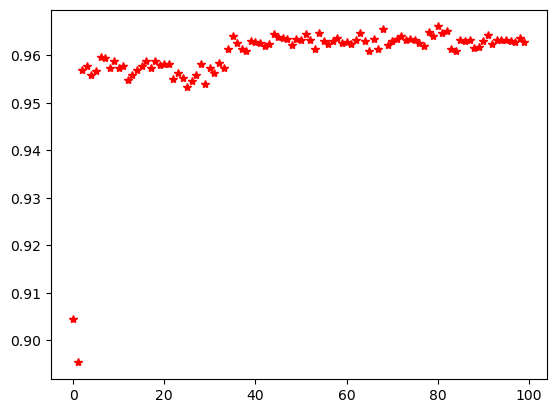

In [26]:
pyplot.plot(fittest_per_generation, "r*")

In [ ]:
population_report()

In [42]:
population = GA.evolve_population(population)

Evolution ... 
*** Old generation ***
vsdo vsdo vsdo
wxco xhxv vsdo
yrui xhxv vsdo
fbvy vsdo rdyl
yeck xhxv rdyl
rdyl rdyl rdyl
hlsa rdyl vsdo
xhxv xhxv xhxv
*** Parents taken over ***
vsdo vsdo vsdo
*** Random parents ***
hlsa rdyl vsdo
wxco xhxv vsdo
*** New generation ***
vsdo vsdo vsdo
hlsa hlsa hlsa
wxco wxco wxco
tanr vsdo wxco
vouo hlsa vsdo
ctzz hlsa wxco
zdyl vsdo wxco
miae wxco hlsa


In [43]:
%%capture
procs = [develop(i,chrm) for i,chrm in enumerate(population)]


2023-07-06 12:01:15.441334: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 12:01:15.525809: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 12:01:15.558889: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

In [36]:
population = sort_population([read_chromosome(chrm.id) for chrm in population])

In [37]:
population_report(population)

--- Chromosome pxap ---
Optimizer: rmsprop
number_of_epochs: 9
steps_per_epoch: 50
number of hidden layers: 2
Layers:
0 {'neurons': 64, 'activation': 'relu', 'rate': None, 'layer_type': 'dense'}
1 {'neurons': None, 'activation': None, 'rate': 0.4, 'layer_type': 'dropout'}
--------------------------------------------------------------------------------
Accuracy: 0.9465500116348267
--- Chromosome hbmd ---
Optimizer: rmsprop
number_of_epochs: 9
steps_per_epoch: 50
number of hidden layers: 2
Layers:
0 {'neurons': 64, 'activation': 'relu', 'rate': None, 'layer_type': 'dense'}
1 {'neurons': None, 'activation': None, 'rate': 0.4, 'layer_type': 'dropout'}
--------------------------------------------------------------------------------
Accuracy: 0.9447000026702881
--- Chromosome janm ---
Optimizer: adam
number_of_epochs: 6
steps_per_epoch: 50
number of hidden layers: 3
Layers:
0 {'neurons': 64, 'activation': 'relu', 'rate': None, 'layer_type': 'dense'}
1 {'neurons': None, 'activation': None, 'r

### Auslese ("Survival of the fittest")

#### Analyse

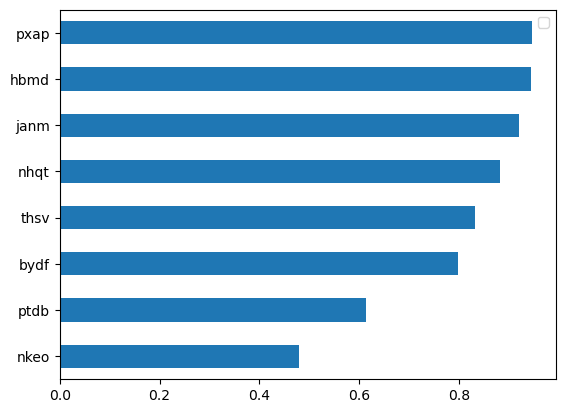

In [38]:
pandas.Series(data=dict([(chrm.id, chrm.accuracy) for chrm in population])).sort_values().plot(kind='barh')
pyplot.legend([])

## Zweite Generation

In [31]:
GA.random_candidates_count

2

In [39]:
population = GA.evolve_population(population)

Evolution ... 
*** Old generation ***
pxap nhqt hbmd
hbmd hbmd hbmd
janm hbmd nhqt
nhqt nhqt nhqt
thsv ptdb hbmd
bydf nhqt ptdb
ptdb ptdb ptdb
nkeo nhqt ptdb
*** Parents taken over ***
pxap nhqt hbmd
*** Random parents ***
nhqt nhqt nhqt
janm hbmd nhqt
*** New generation ***
pxap pxap pxap
nhqt nhqt nhqt
janm janm janm
yrnm janm nhqt
vpuj janm nhqt
fgnk janm pxap
hguz nhqt janm
uzbd nhqt janm


In [35]:
%%capture
procs = [develop(i,chrm) for i,chrm in enumerate(population)]


2023-07-06 11:48:59.956115: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 11:49:00.052403: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-06 11:49:00.090081: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, re

Epoch 1/9
Epoch 1/7
Epoch 1/6
Epoch 1/9
Epoch 1/6
Epoch 1/9
Epoch 1/7
Epoch 1/6


2023-07-06 11:49:05.631414: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f6f0804a830 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-06 11:49:05.631458: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-07-06 11:49:05.635883: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-06 11:49:05.707586: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-07-06 11:49:05.755443: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2023-07-06 11:49:05.919168: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f961427b8c0 initialized for platform CUDA (this doe

 1/10 [==>...........................] - ETA: 10s - loss: 2.6032 - accuracy: 0.0822 

2023-07-06 11:49:06.152920: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fbd110caaf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-06 11:49:06.152955: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-07-06 11:49:06.171492: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-07-06 11:49:06.217440: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2023-07-06 11:49:06.222929: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f3eac9b2650 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-06 11:49:06.222956: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, C

 1/50 [..............................] - ETA: 1:09 - loss: 2.4242 - accuracy: 0.0812

2023-07-06 11:49:06.411979: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f7b29889600 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-06 11:49:06.412012: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-07-06 11:49:06.428934: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-07-06 11:49:06.481402: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2023-07-06 11:49:06.579658: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f3741158d20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-06 11:49:06.579690: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, C

 1/50 [..............................] - ETA: 1:10 - loss: 2.4621 - accuracy: 0.1187

2023-07-06 11:49:06.663559: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-07-06 11:49:06.733035: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10/10 [==============================] - 3s 163ms/step - loss: 2.3006 - accuracy: 0.1302 - val_loss: 2.1850 - val_accuracy: 0.1813
Epoch 2/7
50/50 [==============================] - 3s 35ms/step - loss: 1.0906 - accuracy: 0.6761 - val_loss: 0.5139 - val_accuracy: 0.8769
Epoch 2/9
50/50 [==============================] - 3s 34ms/step - loss: 1.8876 - accuracy: 0.3508 - val_loss: 1.1218 - val_accuracy: 0.7900
Epoch 2/6
10/10 [==============================] - 3s 182ms/step - loss: 2.5158 - accuracy: 0.0999 - val_loss: 2.2958 - val_accuracy: 0.1252
Epoch 2/6
50/50 [==============================] - 3s 31ms/step - loss: 2.2029 - accuracy: 0.1893 - val_loss: 1.9769 - val_accuracy: 0.4547
Epoch 2/9
50/50 [==============================] - 3s 32ms/step - loss: 1.0988 - accuracy: 0.6798 - val_loss: 0.5048 - val_accuracy: 0.8857
Epoch 2/9
50/50 [==============================] - 3s 34ms/step - loss: 2.2128 - accuracy: 0.2054 - val_loss: 1.8937 - val_accuracy: 0.4940
Epoch 2/7
50/50 [===========